In [1]:
from path import Path 
from scipy.stats import pearsonr, spearmanr, wilcoxon

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import os, warnings
warnings.filterwarnings('ignore')
import stan

figsize = stan.figsize
fontsize = stan.fontsize
dpi = stan.dpi

path = Path('df2plot_inR')
if not os.path.exists(path):
    os.makedirs(path)

/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/zhanglinan/anaconda3/envs/bioinfo/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Loading ST dataset

In [2]:
id_list = {'CID4290': 'ER_1', 'CID4535': 'ER_2', 'CID44971': 'TNBC_4',
           'CID4465': 'TNBC_3', '1142243F': 'TNBC_1', '1160920F': 'TNBC_2'}
sample_list = id_list.keys()

adatas = dict() # input of STAN
adatas_stan = dict() # output of STAN
for sample_id in sample_list:
    adatas[sample_id] = sc.read_h5ad("data/Breast_Wu/{}.h5ad".format(sample_id))
    adatas_stan[sample_id] = sc.read_h5ad('outputs_stan/adata_Breast_Wu_{}.h5ad'.format(sample_id))

Extract the inferred TF activity matrix.

In [3]:
adatas_tfa = dict()
for sample_id in sample_list:
    adata = stan.get_activity(adatas_stan[sample_id])
    sc.pp.scale(adata)
    sc.tl.rank_genes_groups(adata, groupby='pathology', method="wilcoxon")
    adatas_tfa[sample_id] = adata

## TF activity score by sample by pathology

In [4]:
import auxiliary_breast as auxbr

dfs_tf_pat = auxbr.make_pat_tf_dataframe(adatas_tfa)
df_tf_pat = pd.concat(dfs_tf_pat, ignore_index=True)

dfs_tf_pat_diff = dict()
for sample in sample_list:
    adata_tfa = adatas_tfa[sample]
    df = dfs_tf_pat[sample]
    df['diff'] = 0
    mat = adata_tfa.to_df()
    for i in df.index:
        tf = df['TF'][i]
        pat = df['Pathology'][i]
        x = mat.loc[adata_tfa.obs['pathology']==pat, tf].mean(numeric_only=True)
        y = mat.loc[adata_tfa.obs['pathology']!=pat, tf].mean(numeric_only=True)
        df['diff'][i] = x-y
    dfs_tf_pat_diff[sample] = df
df_tf_pat_diff = pd.concat(dfs_tf_pat_diff, ignore_index=True)

In [5]:
df_tf_pat_diff

,sample,TF,Pathology,TFa,-log(p_adj),rank,abs_TFa,diff
0,CID4290,STAT3,Invasive cancer + stroma,0.192711,10.000000,0,0.192711,1.362459
1,CID4290,RFX3,Invasive cancer + stroma + lymphocytes,2.087415,10.000000,0,2.087415,2.290489
2,CID4290,ZNF217,Stroma,1.746034,10.000000,0,1.746034,1.838529
3,CID4290,ZNF250,Invasive cancer + stroma,0.255628,10.000000,1,0.255628,1.807284
4,CID4290,NR3C1,Invasive cancer + stroma + lymphocytes,1.656093,10.000000,1,1.656093,1.817206
...,...,...,...,...,...,...,...,...
6478,1160920F,HINFP,DCIS,-3.240349,7.092706,217,3.240349,-3.248399
6479,1160920F,MEIS1,Invasive cancer + stroma + lymphocytes,-0.537416,10.000000,217,0.537416,-1.531589
6480,1160920F,KLF5,Lymphocytes,-2.065810,10.000000,217,2.065810,-2.148336
6481,1160920F,HINFP,Normal glands + lymphocytes,-1.388368,10.000000,217,1.388368,-1.472936


In [10]:
df_tf_pat_diff['sample_rename'] = [id_list[sample] for sample in df_tf_pat_diff['sample']]

In [6]:
def plot_heatmap(data, title):
    x = "TF"
    y = 'sample'
    tfs = data.pivot(index=y, columns=x, values="TFa").dropna(axis=1).columns.to_list()
    data = data.query("TF in @tfs")
    data.to_csv('df2plot_inR/breast_{}.csv'.format(title))
    print(len(tfs))

    data[x] = data[x].astype("category")
    data[y] = data[y].astype("category")
    x_lab = data[x].cat.categories
    y_lab = data[y].cat.categories

    f = sns.clustermap(data.pivot(index=y, columns=x, values="TFa").dropna(axis=1),figsize=(0.1,0.1), cmap='PiYG')
    x_lab = x_lab[f.dendrogram_col.reordered_ind]
    y_lab = y_lab[f.dendrogram_row.reordered_ind]
    print(x_lab)
    print(y_lab)

    data[x] = data[x].cat.reorder_categories(x_lab)
    data[y] = data[y].cat.reorder_categories(y_lab)
    data = data.sort_values([x, y])
    
    data["TFa\n(scaled)"]=data["TFa"].clip(-1, 1)

    figsize = 0.2
    plt.figure(figsize=(figsize*len(x_lab), figsize*len(y_lab)), dpi=dpi)
    plt.rc('font', size=fontsize/1.8) 
    ax = sns.scatterplot(data=data,x=x, y=y, palette="PiYG_r", hue="TFa\n(scaled)", size="-log(p_adj)")
    plt.legend(bbox_to_anchor=(1,1), loc='upper left', columnspacing=0.5, handletextpad=0, frameon=False, 
               fontsize=fontsize/2, ncols=2)

    ax.set_xticklabels(x_lab,rotation = 90)
    ax.set_xlim(-0.5, -0.5+len(x_lab))
    ax.set_ylim(-0.5, -0.5+len(y_lab))
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(title)

36
27
Index(['ZNF76', 'IKZF1', 'CREB3', 'NR2C2', 'GATA6', 'MAFB', 'HINFP', 'CREB1',
       'GABPA', 'SOX17', 'NR5A2', 'SPDEF', 'STAT3', 'TCF4', 'ARNTL', 'HSF2',
       'ZKSCAN1', 'HOXC6', 'GMEB1', 'MEIS1', 'VDR', 'ETV6', 'ELK1', 'TEAD4',
       'MEF2C', 'DBP', 'NFATC1'],
      dtype='object')
Index(['CID4465', 'CID4290', '1142243F', 'CID44971', '1160920F', 'CID4535'], dtype='object')


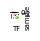

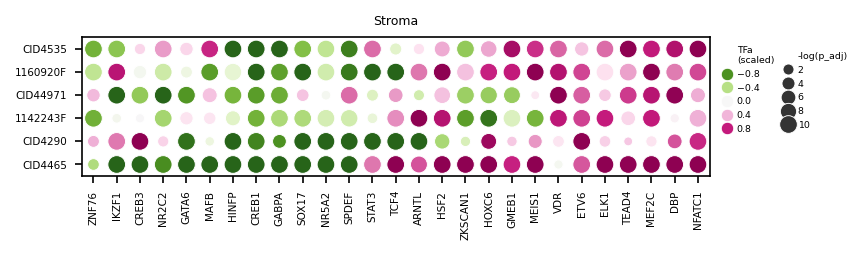

In [11]:
df_stroma = df_tf_pat_diff.query("Pathology == 'Stroma'")
tfs = list()
n = 3
for sample in sample_list:
    adata_tfa = adatas_tfa[sample]
    categories = adata_tfa.obs['pathology'].cat.categories
    for i in range(n):
        for j, cat in enumerate(categories):
            if cat=='Stroma':
                tfs.append(adata_tfa.uns['rank_genes_groups']['names'][i][j])
    for i in range(1,n+1):
        for j, cat in enumerate(categories):
            if cat=='Stroma':
                tfs.append(adata_tfa.uns['rank_genes_groups']['names'][-i][j])
print(len(tfs))
df_filtered = df_stroma.query("TF in @tfs")
plot_heatmap(df_filtered, 'Stroma')

25
23
Index(['RFX5', 'STAT2', 'FOXP3', 'GATA6', 'BACH2', 'STAT5B', 'HOXC6', 'NR2C2',
       'ZKSCAN1', 'NFAT5', 'POU2F1', 'IKZF1', 'MAFB', 'HES1', 'STAT3', 'CREB1',
       'HINFP', 'SPDEF', 'ZNF76', 'GABPA', 'NR5A2', 'SOX17', 'TCF4'],
      dtype='object')
Index(['1160920F', '1142243F', 'CID44971', 'CID4535'], dtype='object')


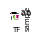

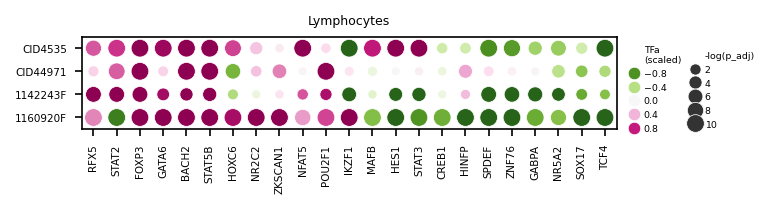

In [12]:
df_lymph = df_tf_pat_diff.query("Pathology == 'Lymphocytes'")
tfs = list()
n = 3
for sample in sample_list:
    adata_tfa = adatas_tfa[sample]
    categories = adata_tfa.obs['pathology'].cat.categories
    for i in range(n):
        for j, cat in enumerate(categories):
            if cat=='Lymphocytes':
                tfs.append(adata_tfa.uns['rank_genes_groups']['names'][i][j])
    for i in range(1,n+1):
        for j, cat in enumerate(categories):
            if cat=='Stroma':
                tfs.append(adata_tfa.uns['rank_genes_groups']['names'][-i][j])
print(len(set(tfs)))

df_filtered = df_lymph.query("TF in @tfs")
plot_heatmap(df_filtered, 'Lymphocytes')

24
21
Index(['RFX3', 'ZNF76', 'MAFB', 'NR3C1', 'GMEB1', 'GATA6', 'HOXC6', 'ZKSCAN1',
       'IKZF1', 'CREB1', 'STAT3', 'TCF4', 'SOX17', 'TAL1', 'NR2C2', 'NR5A2',
       'GABPA', 'SPDEF', 'HINFP', 'E2F1', 'FOXM1'],
      dtype='object')
Index(['CID4290', '1160920F', '1142243F', 'CID4465'], dtype='object')


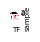

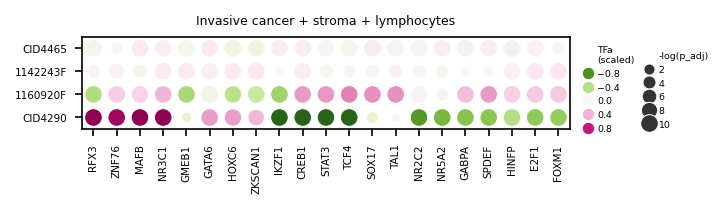

In [13]:
df_ic = df_tf_pat_diff.query("Pathology == 'Invasive cancer + stroma + lymphocytes'")

tfs = list()
n = 3
for sample in sample_list:
    adata_tfa = adatas_tfa[sample]
    categories = adata_tfa.obs['pathology'].cat.categories
    for i in range(n):
        for j, cat in enumerate(categories):
            if cat=='Invasive cancer + stroma + lymphocytes':
                tfs.append(adata_tfa.uns['rank_genes_groups']['names'][i][j])
    for i in range(1,n+1):
        for j, cat in enumerate(categories):
            if cat=='Stroma':
                tfs.append(adata_tfa.uns['rank_genes_groups']['names'][-i][j])
print(len(set(tfs)))

df_filtered = df_ic.query("TF in @tfs")
plot_heatmap(df_filtered, 'Invasive cancer + stroma + lymphocytes')

In [32]:
def plot_heatmap_correlation(data, title, figsize1=2.4, figsize2=2.4):
    n = len(data['sample_rename'].unique())-1
    plt.figure(figsize=(figsize1, figsize2), dpi=dpi)
    plt.rc('font', size=fontsize)
    ax = sns.heatmap(data.pivot(columns="sample_rename", index="TF", values="TFa").dropna().corr().round(2).iloc[1:,:-1],
                cmap="coolwarm", center=0, annot=True, mask=np.tril(np.ones(n)-np.eye(n)).T, vmax=0.6, vmin=-0.6, fmt='.2f')
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0, ha='right')
    plt.title(title)
    plt.legend(title='Pearson r', frameon=False)

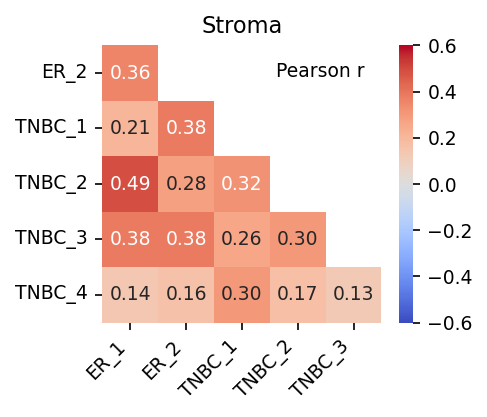

In [33]:
plot_heatmap_correlation(df_stroma, "Stroma", figsize1=3)

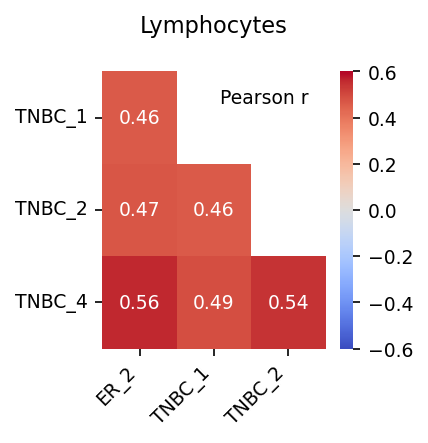

In [35]:
plot_heatmap_correlation(df_lymph, "Lymphocytes\n")

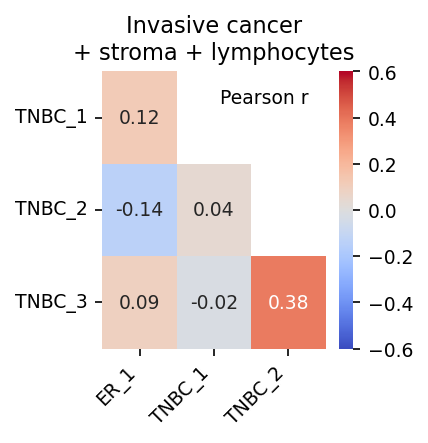

In [36]:
plot_heatmap_correlation(df_ic, "Invasive cancer\n+ stroma + lymphocytes")

## TF activity score by pathology by sample

In [37]:
dfs_tf_pat_top = dict()
for sample in sample_list:
    adata_tfa = adatas_tfa[sample]
    categories = adatas_tfa[sample].obs['pathology'].cat.categories
#     top_tfs = [ x for sub in adata_tfa.uns['rank_genes_groups']['names'][:3] for x in sub] + [ x for sub in adata_tfa.uns['rank_genes_groups']['names'][-3:] for x in sub] 
#     print(top_tfs)
    if len(categories)>3:
        top_tfs = [ x for sub in adata_tfa.uns['rank_genes_groups']['names'][:3] for x in sub] + [ x for sub in adata_tfa.uns['rank_genes_groups']['names'][-3:] for x in sub]
        print(f'Here: {len(top_tfs)}')
    else:
        top_tfs = [ x for sub in adata_tfa.uns['rank_genes_groups']['names'][:5] for x in sub] + [ x for sub in adata_tfa.uns['rank_genes_groups']['names'][-5:] for x in sub] 
        print(f'There: {len(top_tfs)}')
    df = dfs_tf_pat_diff[sample].query("TF in @top_tfs")
    df['TF'] = df['TF'].astype("category").cat.remove_unused_categories()
    dfs_tf_pat_top[sample] = df

There: 30
Here: 36
Here: 36
There: 30
Here: 30
Here: 42


In [38]:
for sample in sample_list:
    df = dfs_tf_pat_top[sample]
    df.to_csv('df2plot_inR/breast_tf_by_pathology_{}.csv'.format(sample))
    print(sample)
    auxbr.dendrogram_order(df)

CID4290
Index(['BACH1', 'HBP1', 'MYBL2', 'NR5A2', 'SPDEF', 'HSF2', 'TP53', 'ZNF250',
       'STAT6', 'STAT3', 'TCF4', 'CREB3', 'ETV6', 'ZNF217', 'ELF2', 'HOXA4',
       'SP2', 'MAZ', 'NR3C1', 'MAFB', 'RFX3'],
      dtype='object')
Index(['Stroma', 'Invasive cancer + stroma',
       'Invasive cancer + stroma + lymphocytes'],
      dtype='object')
CID4535
Index(['LEF1', 'SP2', 'NFE2L2', 'ZNF250', 'HINFP', 'ZNF236', 'ZNF76', 'CREB1',
       'GABPA', 'SREBF2', 'RXRA', 'ETV5', 'NFYC', 'HOXA9', 'TCF4', 'ARNTL',
       'FOXO3', 'E2F7', 'NR3C1', 'GMEB1', 'SOX2', 'ZFHX3', 'CREB3', 'CUX1',
       'HES1', 'BARX2', 'BACH2', 'NFAT5', 'NFATC1', 'TEAD4'],
      dtype='object')
Index(['Adipose tissue', 'Invasive cancer + adipose tissue + lymphocytes',
       'Invasive cancer', 'Invasive cancer + lymphocytes', 'Lymphocytes',
       'Stroma'],
      dtype='object')
CID44971
Index(['STAT3', 'ARNTL', 'TP73', 'IKZF1', 'NR2C2', 'SREBF2', 'FOXP3', 'STAT5B',
       'MITF', 'BACH1', 'HSF2', 'KLF5', 'ZNF250', '